## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import torch

if not torch.cuda.is_available():
    raise SystemError('GPU device not found')
print(f'Found GPU at: {torch.cuda.get_device_name(torch.cuda.current_device())}')

# Notes on Python

## Basic Python

### Variable Types

In [ ]:
integer_var = 10
float_var = 5.5
string_var = "Hello, World!"
boolean_var = True


### Conditional Statements

In [ ]:
age = 17

if age < 18:
    print("You are a minor.")
elif age >= 18 and age < 65:
    print("You are an adult.")
else:
    print("You are a senior.")

### Loops

In [ ]:
# for loop
for i in range(5):  # range(5) generates numbers from 0 to 4
    print(i)

In [ ]:
# while loop
counter = 0
while counter < 5:
    print(counter)
    counter += 1

### Functions

In [ ]:
def greet(name):
    print("Hello " + name)

greet("John")
greet("Jane")

### Lists


In [ ]:
fruits = ["apple", "banana", "orange"]
fruits
fruits.append("grape")
fruits
fruits.remove("banana")
fruits

fruits[0]
fruits[0] = "pineapple"
fruits

In [ ]:
fruits

## Python Libraries

Python libraries are like R packages. They often have extensive documentation online. We will use the following python packages in this tutorial:

- numpy: math and working with matrices
- pandas: cleaning/wrangling data frames
- sklearn: machine learning toolkit
- matplotlib: plotting
- seaborn: more plotting
- torch: neural networks, backprop optimization

# Read In Data
In this tutorial we will forecast measles incidence using neural networks in PyTorch. We will employ the seminal England and Wales pre-vaccination bi-weekly measles dataset (a description of which can be found [here](https://doi.org/10.1371/journal.pcbi.1010251)).
We will work with the thirty most populous cities from 1949-1965.  

In [ ]:
import pandas as pd
import requests
import io

# URL of the raw Parquet file on GitHub
url = 'https://raw.githubusercontent.com/WyattGMadden/intro_to_ml_for_id_emory/main/data/england_and_wales_measles/uk_measles_30_cities.parquet'

# Make a request to get the Parquet file
r = requests.get(url)
data = io.BytesIO(r.content)
measles = pd.read_parquet(data)

# Explore Data

Lets explore the data with some plots and summaries.

In [ ]:
print(measles)

In [ ]:
# example of method
# first n rows of data frame
measles.head()

In [ ]:
# example of attribute
# list of data frame columns
measles.columns

In [ ]:
for i in measles.columns:
  print(i)

In [ ]:
# get second column
measles.cases

In [ ]:
# get value in second row, first column
measles.iloc[1, 0]

In [ ]:
# dimensions
measles.nearest_big_city_distances_unscaled

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='time', y='cases', hue='city', style='city', dashes=False, alpha=0.5)
plt.title('Measles Cases Over Time by City')
plt.xticks(rotation=45)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc=2, fontsize='x-small')
plt.tight_layout()
plt.show()


## Exercise

- Make a plot of just the London cases over time.

# Split Data Into Train/Test/Validation


In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler

# split measles into train/test
measles_train = measles[measles["time"] < 60]
measles_test = measles[measles["time"] >= 60]

# split heart data into features and target
stand = StandardScaler()
measles_train_features = measles_train.drop(["time", "city", "cases"], axis = 1).to_numpy()
measles_test_features = measles_test.drop(["time", "city", "cases"], axis = 1).to_numpy()
measles_train
# standardize cases in training and test set
measles_train_target = stand.fit_transform(measles_train[["cases"]])
measles_test_target = stand.transform(measles_test[["cases"]])



In [ ]:
measles_train_features.shape

In [ ]:
measles_test_features.shape

In [ ]:
measles_train_target

# Pytorch Neural Net

## Design and Run Model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


# data is prepared for pytorch by using the Dataset class
# this allows the dataset to be easily batched and iterated through
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.from_numpy(y).float()
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


# create Dataset/DataLoader class instances from measles data
train = Data(measles_train_features, measles_train_target)
train_loader = DataLoader(train, batch_size = 256, shuffle = False)

test = Data(measles_test_features, measles_test_target)

In [ ]:
# inspect the first batch of the heart trianing data dataloader instance
for i, (features, targets) in enumerate(train_loader):
  print(features.shape, targets.shape)
  print(features)
  print(targets)
  break;


In [ ]:
# all pytorch neural nets have the same basic form (class)
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            )
    def forward(self, x):
        #x = self.flatten(x)
        return self.linear_relu_stack(x)


# create the specific model instance that will be used to fit the neural net on the heart data
model = NeuralNetwork(
    input_dim = measles_train_features.shape[1],
    hidden_dim = int(measles_train_features.shape[0] * (2/3)),
    output_dim = measles_train_target.shape[1])
model

In [ ]:
# choose the loss function
loss_fn = nn.MSELoss()

# choose the optimization routine
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# choose the number of times the model runs through all the measles data
num_epochs = 1

# create empty lists to store the train/test loss at each epoch
train_loss_values = []
test_loss_values = []

# tell pytorch that we are starting the training process
model.train()


# fit the model epoch * batch_size number of times.
# Each time updates the parameters
for epoch in range(num_epochs):
    print("Starting Epoch: " + str(epoch))
    train_loss = 0
    i = 1
    for features, target in train_loader:

        # keep track of batch number
        i += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # run the model on batched test features
        pred = model(features)

        # calculate loss
        loss = loss_fn(pred, target)

        # add loss to training_loss for accounting purposes
        train_loss += loss.item()

        # backpropogate loss
        loss.backward()

        # update parameters
        optimizer.step()

        print("Batch number: " + str(i))

    # save train/test set performance, append to lists
    with torch.no_grad():
      train_loss_values.append(train_loss / i)
      test_pred = model(test.X)
      test_loss = loss_fn(test_pred, test.y)
      test_loss_values.append(test_loss.item())

    # print the training loss to monitor during fitting
    print("Finishing Epoch: " + str(epoch))
    print("Loss: " + str(train_loss / i))

print("Training Complete")

## Evaluate Model

First let's plot the train/test loss over fit iterations. The train loss (blue) quickly decreases and then levels off. The test loss (orange) slowly decreases, and then starts to increase due to overfitting.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0, len(train_loss_values)), train_loss_values, color = "blue")
plt.plot(range(0, len(train_loss_values)), test_loss_values, color = "orange")

In [ ]:
# tell pytorch that we are no longer fitting the model
# parameters will no longer update
model.eval()

# get model predictions for train/test/validation data sets
test_preds = model(test.features)
train_preds = model(train.features)
valid_preds = model(valid.features)

test_preds_np = test_preds.detach().numpy().flatten()
test_np = test.target.numpy().flatten()

train_preds_np = train_preds.detach().numpy().flatten()
train_np = train.target.numpy().flatten()

valid_preds_np = valid_preds.detach().numpy().flatten()
valid_np = valid.target.numpy().flatten()


valid_preds_np

valid_preds_np > 0.5


In [ ]:
accuracy_score(valid_np, valid_preds_np > 0.1)

In [ ]:
accuracy_score(valid_np, valid_preds_np > 0.2)

In [ ]:
accuracy_score(valid_np, valid_preds_np > 0.5)

True positive percent (percent of positives accurately predicted)

In [ ]:
actual_positive = (test_np == 1)
num_actual_positive = np.sum(actual_positive)

predicted_positive = (test_preds_np > 0.01)
actual_and_predicted_positive = np.logical_and(actual_positive, predicted_positive)
num_actual_and_predicted_positive = np.sum(actual_and_predicted_positive)

true_positive_percent = (num_actual_and_predicted_positive / num_actual_positive) * 100
true_positive_percent

True negative percent (percent of negatives accurately predicted)

In [ ]:
actual_negative = (test_np == 0)
num_actual_negative = np.sum(actual_negative)

predicted_negative = (test_preds_np <= 0.01)
actual_and_predicted_negative = np.logical_and(actual_negative, predicted_negative)
num_actual_and_predicted_negative = np.sum(actual_and_predicted_negative)

true_negative_percent = (num_actual_and_predicted_negative / num_actual_negative) * 100
true_negative_percent

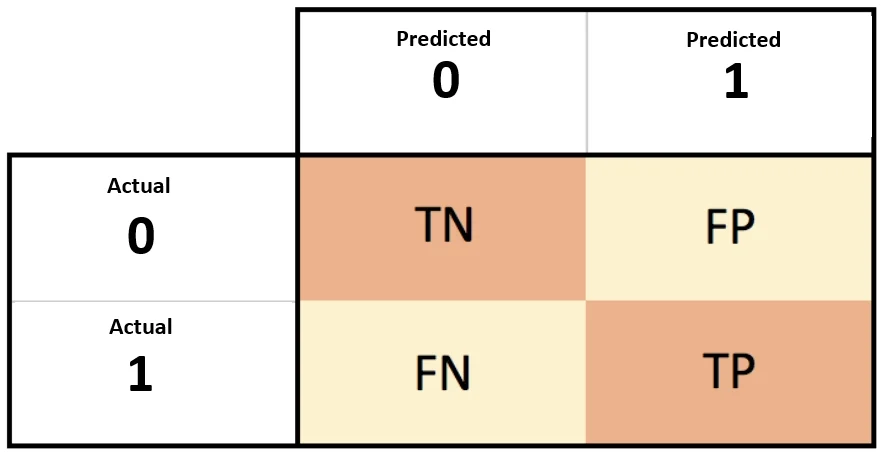

In [ ]:
confusion_matrix(train_np, train_preds_np > 0.5)

In [ ]:
confusion_matrix(test_np, test_preds_np > 0.1)

In [ ]:
confusion_matrix(valid_np, valid_preds_np > 0.1)

In [ ]:
def plot_roc_curve(true_y, y_pred):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(train_np, train_preds_np)

In [ ]:
plot_roc_curve(test_np, test_preds_np)

In [ ]:
plot_roc_curve(valid_np, valid_preds_np)

In [ ]:
print(classification_report(valid_np, valid_preds_np > 0.1))

In [ ]:
print(classification_report(valid_np, valid_preds_np > 0.5))

## Exercises
- Experiment with different hyperparameters/architectures, and investigate change in performance. For example, you could change batch size, optimizer, learning rate (and other optimizer parameters), hidden layer dimension, number of hidden layers, activation function, etc..

Some useful links:
- https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
- https://pytorch.org/docs/stable/optim.html

# Additional Resources

# Neural Networks/Deep Learning

- guide to Google Colab: https://colab.research.google.com/notebooks/welcome.ipynb#scrollTo=-Rh3-Vt9Nev9

- Fast.ai Deep Learning Course https://course19.fast.ai/index.html

- MNIST in pytorch: https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb

- Andrej Karpathy's (OpenAI, former director AI at Tesla) Neural Networks: Zero to Hero Youtube course https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

- UvA Deep Learning Tutorials https://uvadlc-notebooks.readthedocs.io/en/latest/index.html

- Dive Into Deep Learning (applied deep learning textbook/examples) https://d2l.ai/

# General Python

- https://docs.python.org/3/tutorial/